In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.1)


In [50]:
# File maps
price_files = {
    -2: "./round-1-island-data-bottle/prices_round_1_day_-2.csv",
    -1: "./round-1-island-data-bottle/prices_round_1_day_-1.csv",
     0: "./round-1-island-data-bottle/prices_round_1_day_0.csv"
}

trade_files = {
    -2: "./round-1-island-data-bottle/trades_round_1_day_-2.csv",
    -1: "./round-1-island-data-bottle/trades_round_1_day_-1.csv",
     0: "./round-1-island-data-bottle/trades_round_1_day_0.csv"
}

# Load and offset timestamps by 1M steps
OFFSET = 1_000_000
squid_prices_full = []
squid_trades_full = []

for i, (day, pf) in enumerate(price_files.items()):
    df = pd.read_csv(pf, sep=';')
    df = df[df['product'] == 'SQUID_INK'].copy()
    df['timestamp'] += i * OFFSET
    df['day'] = day
    squid_prices_full.append(df)

for i, (day, tf) in enumerate(trade_files.items()):
    df = pd.read_csv(tf, sep=';')
    df = df[df['symbol'] == 'SQUID_INK'].copy()
    df['timestamp'] += i * OFFSET
    df['day'] = day
    squid_trades_full.append(df)

# Combine
squid_prices = pd.concat(squid_prices_full, ignore_index=True).sort_values('timestamp')
squid_trades = pd.concat(squid_trades_full, ignore_index=True).sort_values('timestamp')

len(squid_prices), len(squid_trades)

(30000, 8837)

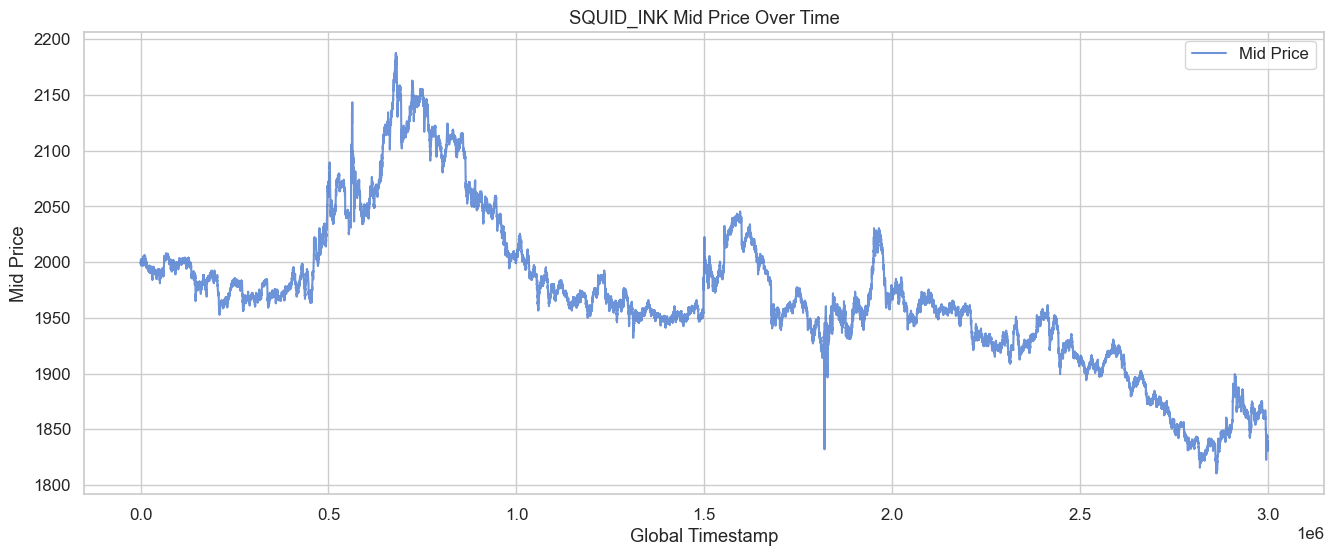

In [51]:
# Mid price over time
squid_prices['mid_price'] = squid_prices['mid_price']

plt.figure(figsize=(16, 6))
plt.plot(squid_prices['timestamp'], squid_prices['mid_price'], label='Mid Price', alpha=0.8)
plt.title('SQUID_INK Mid Price Over Time')
plt.xlabel('Global Timestamp')
plt.ylabel('Mid Price')
plt.legend()
plt.show()


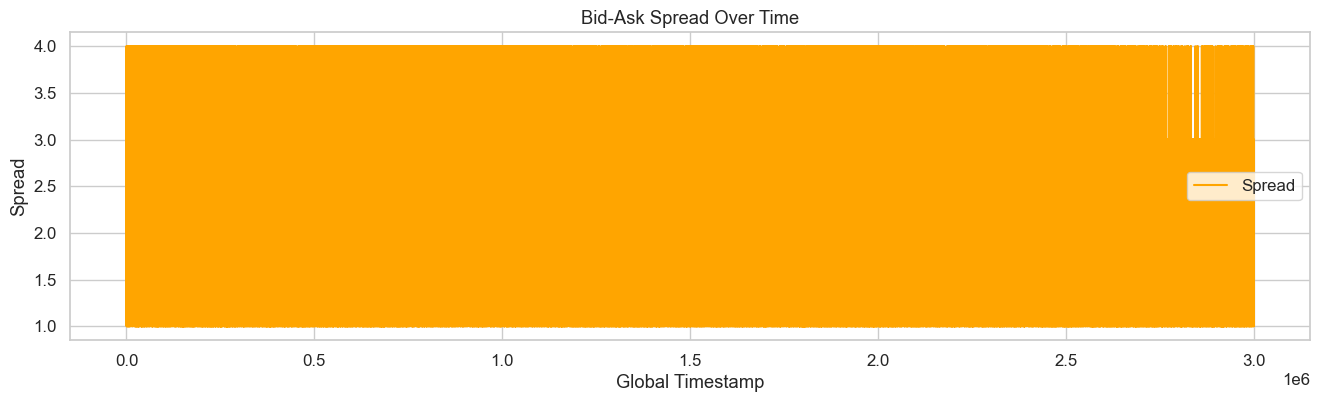

In [52]:
# Spread
squid_prices['spread'] = squid_prices['ask_price_1'] - squid_prices['bid_price_1']

plt.figure(figsize=(16, 4))
plt.plot(squid_prices['timestamp'], squid_prices['spread'], color='orange', label='Spread')
plt.title('Bid-Ask Spread Over Time')
plt.xlabel('Global Timestamp')
plt.ylabel('Spread')
plt.legend()
plt.show()

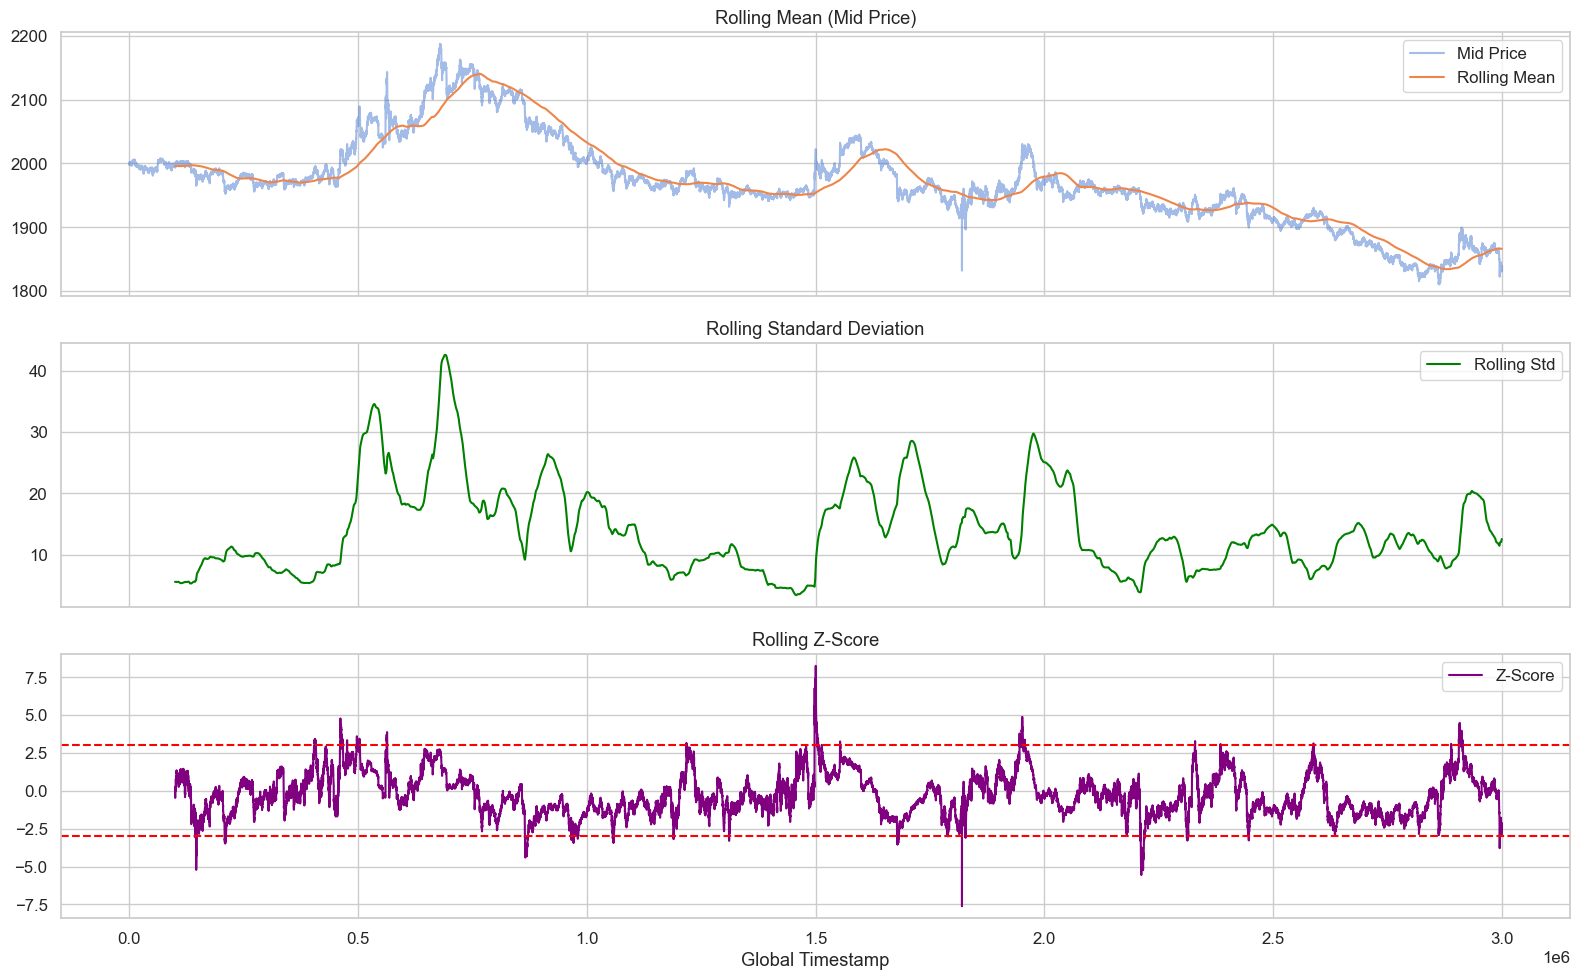

In [53]:
# Rolling stats
WINDOW = 1000
squid_prices['rolling_mean'] = squid_prices['mid_price'].rolling(WINDOW).mean()
squid_prices['rolling_std'] = squid_prices['mid_price'].rolling(WINDOW).std()
squid_prices['z_score'] = (squid_prices['mid_price'] - squid_prices['rolling_mean']) / squid_prices['rolling_std']


fig, axs = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# plot rolling mean, atop of price
axs[0].plot(squid_prices['timestamp'], squid_prices['mid_price'], label='Mid Price', alpha=0.5)
axs[0].plot(squid_prices['timestamp'], squid_prices['rolling_mean'], label='Rolling Mean')
axs[0].set_title('Rolling Mean (Mid Price)')
axs[0].legend()

axs[1].plot(squid_prices['timestamp'], squid_prices['rolling_std'], label='Rolling Std', color='green')
axs[1].set_title('Rolling Standard Deviation')
axs[1].legend()

axs[2].plot(squid_prices['timestamp'], squid_prices['z_score'], label='Z-Score', color='purple')
axs[2].axhline(3, color='red', linestyle='--')
axs[2].axhline(-3, color='red', linestyle='--')
axs[2].set_title('Rolling Z-Score')
axs[2].legend()

plt.xlabel('Global Timestamp')
plt.tight_layout()
plt.show()


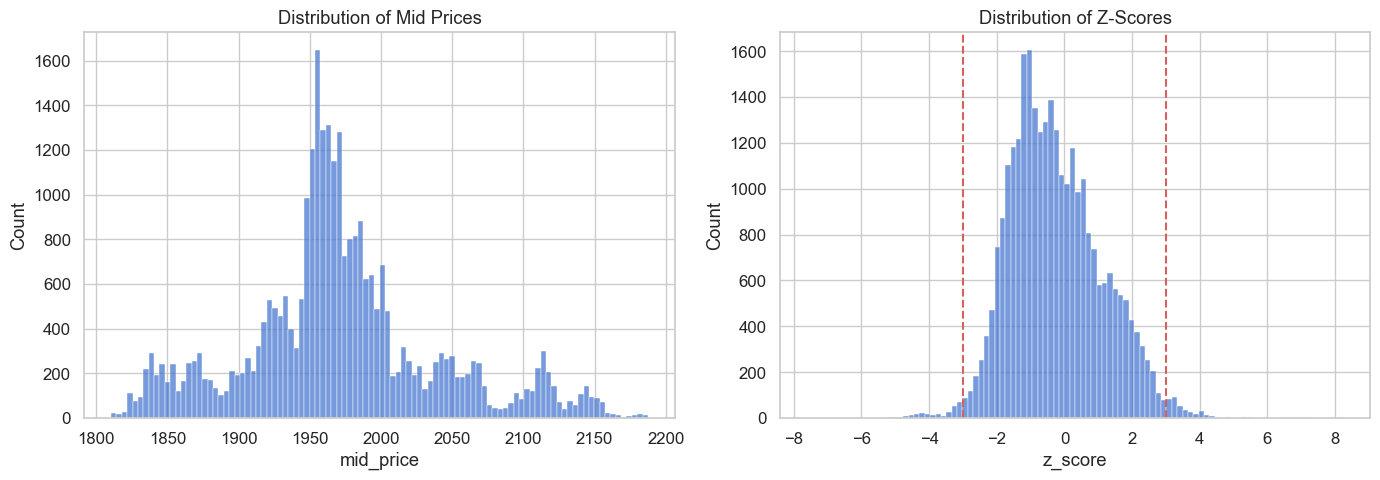

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(squid_prices['mid_price'], bins=100, ax=axs[0])
axs[0].set_title("Distribution of Mid Prices")

sns.histplot(squid_prices['z_score'].dropna(), bins=100, ax=axs[1])
axs[1].axvline(3, color='r', linestyle='--')
axs[1].axvline(-3, color='r', linestyle='--')
axs[1].set_title("Distribution of Z-Scores")

plt.tight_layout()
plt.show()


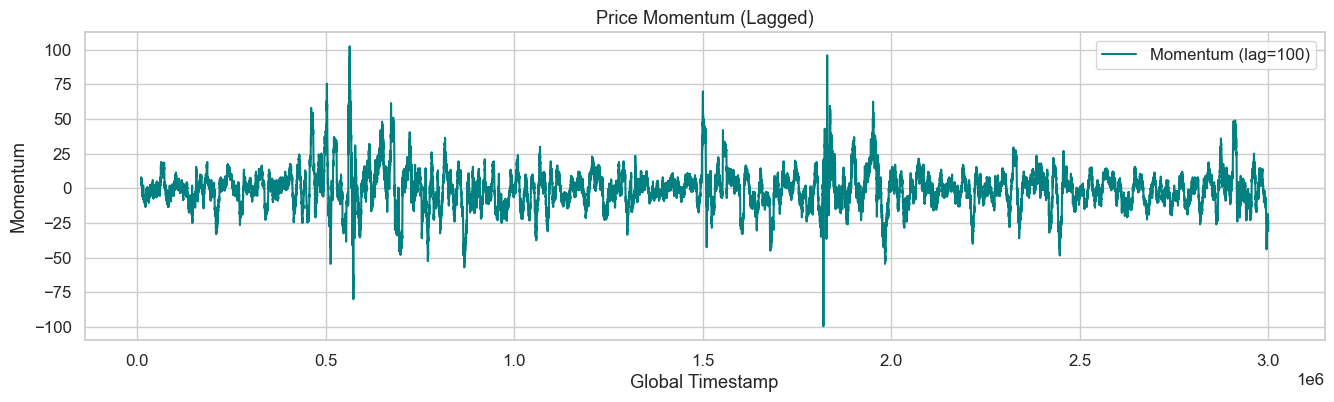

In [55]:
# Momentum = price(t) - price(t - lag)
LAG = 100
squid_prices['momentum'] = squid_prices['mid_price'] - squid_prices['mid_price'].shift(LAG)

plt.figure(figsize=(16, 4))
plt.plot(squid_prices['timestamp'], squid_prices['momentum'], label=f'Momentum (lag={LAG})', color='teal')
plt.title('Price Momentum (Lagged)')
plt.xlabel('Global Timestamp')
plt.ylabel('Momentum')
plt.legend()
plt.show()


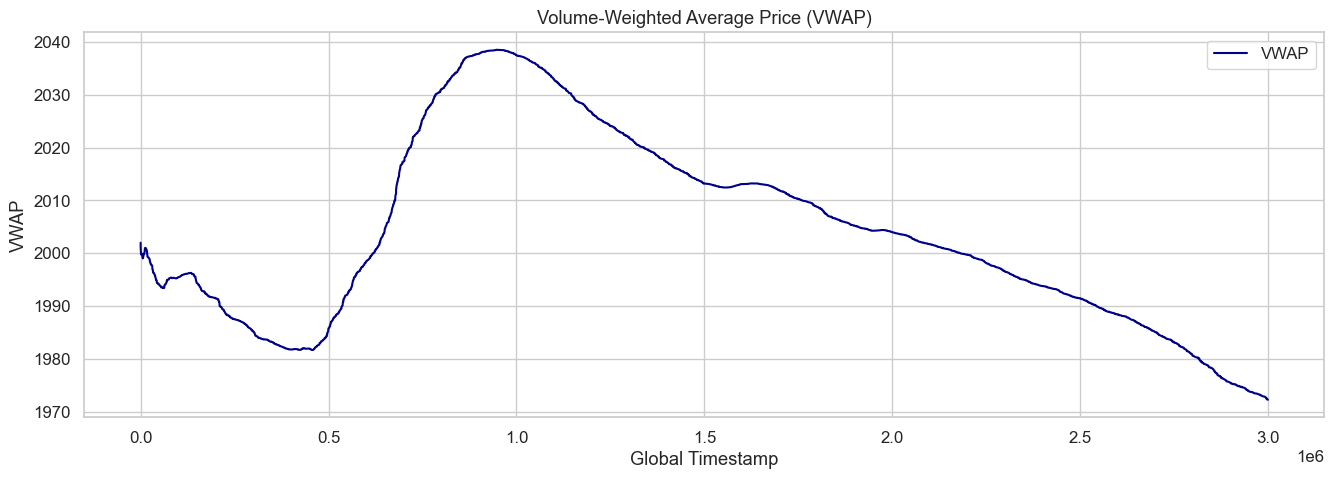

In [56]:
# VWAP from trade data
squid_trades['vwap_price'] = squid_trades['price'] * squid_trades['quantity']
squid_trades['vwap'] = squid_trades['vwap_price'].cumsum() / squid_trades['quantity'].cumsum()

plt.figure(figsize=(16, 5))
plt.plot(squid_trades['timestamp'], squid_trades['vwap'], label='VWAP', color='darkblue')
plt.title('Volume-Weighted Average Price (VWAP)')
plt.xlabel('Global Timestamp')
plt.ylabel('VWAP')
plt.legend()
plt.show()
